In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pingouin as pg
OUTDATE_IGNORE= 1
import imblearn
import numpy as np
import shap
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import missingno as msn
plt.style.use('dark_background')
%matplotlib inline

C:\Users\smurk\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
df= pd.read_csv('adult.csv')
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [4]:
df.drop(columns= ['education'], inplace=True)

KeyError: "['education'] not found in axis"

In [5]:
df.replace(to_replace= '?', value= np.nan, inplace=True)

<AxesSubplot:>

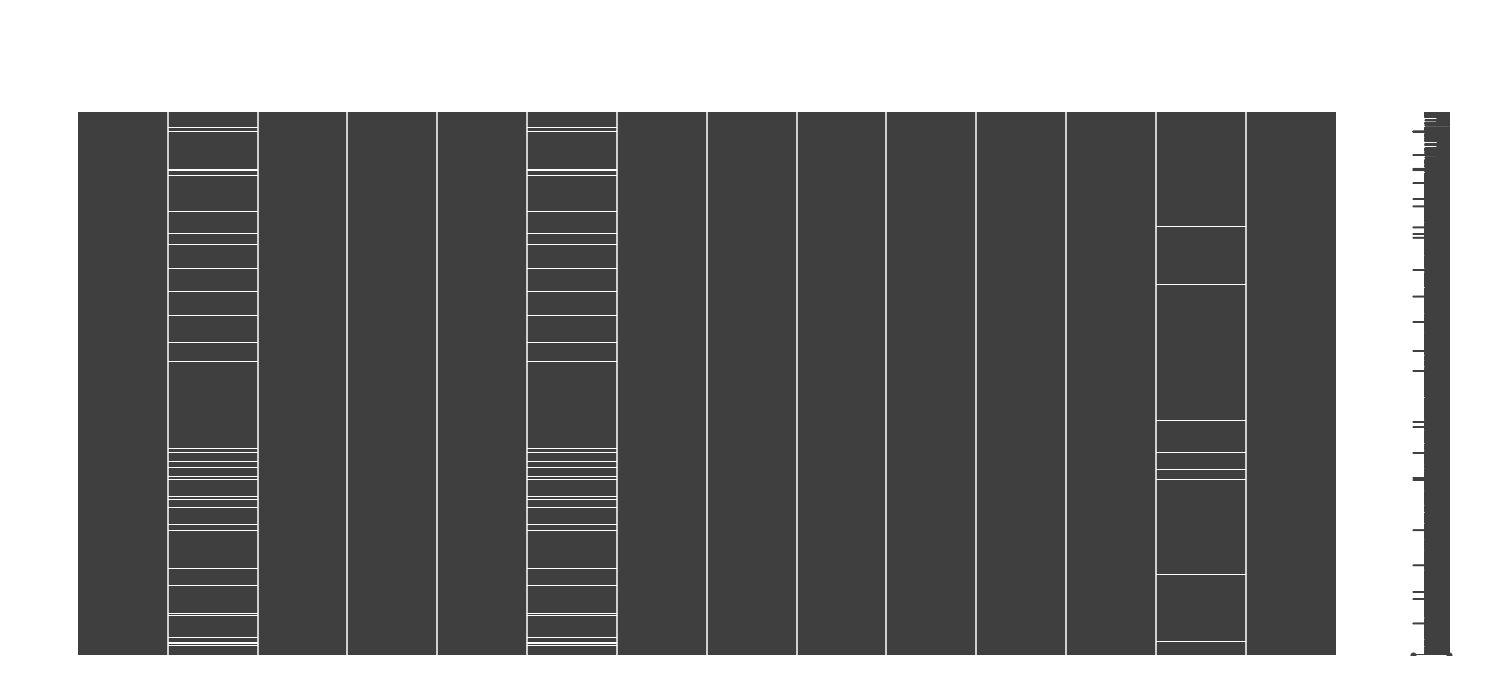

In [6]:
msn.matrix(df)

In [7]:
df1= df.dropna(how= 'any')
df1.shape

(30162, 14)

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


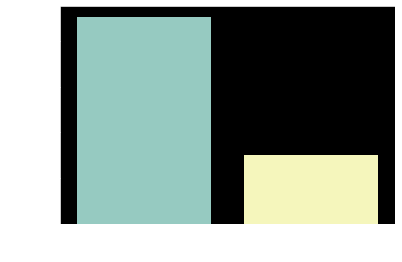

In [8]:
sns.countplot(df1['income'])
plt.show();

In [9]:
X= df1.iloc[:, :-1]
y= df1.iloc[:, -1]
X= pd.get_dummies(X, columns= ['workclass', 
                            'marital.status',
                            'occupation', 
                            'relationship', 
                            'race', 'sex', 'native.country'])

from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
y= encoder.fit_transform(y)

In [10]:
from sklearn.model_selection import train_test_split
X_tr, x_t, Y_tr, y_t= train_test_split(X, y, test_size= 0.2)


In [13]:
from collections import Counter
print(Counter(Y_tr))

Counter({0: 15969, 1: 15969})


In [12]:
from imblearn.combine import SMOTETomek
smt= SMOTETomek()
X_tr, Y_tr= smt.fit_resample(X_tr, Y_tr)

In [14]:
from sklearn.linear_model import LogisticRegression
logreg= LogisticRegression(solver= 'liblinear')
logreg.fit(X_tr, Y_tr)

LogisticRegression(solver='liblinear')

In [15]:
print(confusion_matrix(logreg.predict(x_t), y_t))
print(f1_score(logreg.predict(x_t), y_t))

[[4112  515]
 [ 415  991]]
0.6806318681318682


In [16]:
from sklearn.model_selection import KFold, cross_val_score
kf= KFold(n_splits= 10)
results= cross_val_score(logreg, X, y, cv= kf)
print(results)
print(np.mean(results))

[0.28306265 0.72257209 0.80736074 0.81100796 0.80238727 0.80039788
 0.80603448 0.7964191  0.80072944 0.80039788]
0.7430369484503816


In [21]:
from sklearn.tree import DecisionTreeClassifier
dtmodel= DecisionTreeClassifier(criterion= 'gini')


In [18]:
from sklearn.model_selection import KFold
kf= KFold(n_splits= 10)

In [19]:
from sklearn.model_selection import cross_val_score
results= cross_val_score(dtmodel, X, y, cv= kf)
print(np.mean(results))

0.7856288832776951


In [22]:
pred_dt= dtmodel.predict(x_t)
print(confusion_matrix(pred_dt, y_t))
print(f1_score(pred_dt, y_t))


NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [29]:
from sklearn.model_selection import GridSearchCV
dt_model_1= DecisionTreeClassifier()
max_depth= np.array([None, 3, 5, 10, 20, 50])
max_feat= np.array([None, 'sqrt', 'log2'])

params= dict(max_depth= max_depth, max_features= max_feat)
grid= GridSearchCV(estimator= dt_model_1,param_grid= params, 
                   n_jobs= -1, verbose= 2, scoring= 'accuracy')

grid.fit(X_tr, Y_tr)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([None, 3, 5, 10, 20, 50], dtype=object),
                         'max_features': array([None, 'sqrt', 'log2'], dtype=object)},
             scoring='accuracy', verbose=2)

In [30]:
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 20, 'max_features': None}


In [37]:
dt_model_2= DecisionTreeClassifier(max_depth= 20, max_features= None)
dt_model_2.fit(X_tr, Y_tr)


DecisionTreeClassifier(max_depth=20)

In [38]:
from sklearn.metrics import accuracy_score
print(accuracy_score(dt_model_2.predict(x_t), y_t))

0.8133598541355876


In [61]:
list(zip(X.columns, dtmodel.feature_importances_))

[('age', 0.08020595497528507),
 ('fnlwgt', 0.10103985166430544),
 ('education.num', 0.10318367837080067),
 ('capital.gain', 0.06453299691594147),
 ('capital.loss', 0.01659004373075052),
 ('hours.per.week', 0.06805215994616692),
 ('workclass_Federal-gov', 0.004045838776195679),
 ('workclass_Local-gov', 0.007696798318848889),
 ('workclass_Private', 0.014725211378837309),
 ('workclass_Self-emp-inc', 0.0051989524987547334),
 ('workclass_Self-emp-not-inc', 0.015267829363420523),
 ('workclass_State-gov', 0.005002906030820761),
 ('workclass_Without-pay', 0.0),
 ('marital.status_Divorced', 0.10827845818820815),
 ('marital.status_Married-AF-spouse', 0.0001150896980334048),
 ('marital.status_Married-civ-spouse', 0.0017834554328292971),
 ('marital.status_Married-spouse-absent', 0.0021250303164957384),
 ('marital.status_Never-married', 0.23293789134777815),
 ('marital.status_Separated', 0.007934813672412128),
 ('marital.status_Widowed', 0.0031577451102306124),
 ('occupation_Adm-clerical', 0.011038

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier= RandomForestClassifier(n_estimators= 50, n_jobs= -1, verbose= 3)

In [24]:
from sklearn.model_selection import KFold
kf= KFold(n_splits= 10)

In [25]:
from sklearn.model_selection import cross_val_score
results= cross_val_score(rf_classifier, X, y, cv= kf)
print(np.mean(results))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]:

0.8238563370783949


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [131]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
rf_class_1= RandomForestClassifier(n_jobs= -1)

est= np.array([10, 20, 50, 100, 200])
max_depth= np.array([3, 5, 7, 9, 13, 20, 50, None])
max_feat= np.array(['auto', 'sqrt', 'log2'])
max_leafs= np.array([3, 5, 7, 15, 20, 40, None])

params= dict(n_estimators= est, max_depth= max_depth, 
             max_features= max_feat, max_leaf_nodes= max_leafs)

grid= GridSearchCV(estimator= rf_class_1, param_grid= params, scoring= 'accuracy', 
                   n_jobs=-1)
res= grid.fit(X_tr, Y_tr)

In [133]:
print(grid.best_score_)
params_best= grid.best_params_
params_best

0.896763221728342


{'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'n_estimators': 200}

In [127]:
from sklearn.metrics import accuracy_score

In [135]:
rf_class_2= RandomForestClassifier(max_depth= 20,
 max_features= 'sqrt',
 max_leaf_nodes= None,
 n_estimators= 200, n_jobs= -1)
results= cross_val_score(rf_class_2, X, y, cv= kf)
print(results)
print(np.mean(results))

[0.69008949 0.83493537 0.85278515 0.86306366 0.85344828 0.85377984
 0.85676393 0.86041114 0.85278515 0.84648541]
0.8364547405550686


In [90]:
from sklearn.ensemble import AdaBoostClassifier
ada_model= AdaBoostClassifier(n_estimators= 70, algorithm= 'SAMME.R', learning_rate= 1)
ada_model.fit(X_tr, Y_tr)

AdaBoostClassifier(learning_rate=1, n_estimators=70)

In [91]:
print(confusion_matrix(ada_model.predict(x_t), y_t))
print(f1_score(ada_model.predict(x_t), y_t))

[[4034  446]
 [ 513 1040]]
0.6844356696281672


In [145]:
rf_class_2.fit(X_tr, Y_tr)
print(accuracy_score(rf_class_2.predict(x_t), y_t))
print(confusion_matrix(rf_class_2.predict(x_t), y_t))

0.8503232222774739
[[4065  421]
 [ 482 1065]]


In [92]:
from sklearn.model_selection import KFold, cross_val_score
kf= KFold(n_splits= 10)
results= cross_val_score(ada_model, X, y, cv= kf)
print(results)
print(np.mean(results))

[0.82896917 0.84123301 0.84482759 0.85477454 0.84151194 0.85245358
 0.85775862 0.86007958 0.85643236 0.84681698]
0.8484857360017374


In [ ]:
import xgboost


In [102]:
D_tr= xgboost.DMatrix(X_tr, label= Y_tr)
D_t= xgboost.DMatrix(x_t, label= y_t)

In [107]:
from xgboost import XGBClassifier
xgbmodel= XGBClassifier(n_estimators= 100, n_jobs= -1, verbosity= 3, eval_metric= 'logloss')
xgbmodel.fit(X_tr, Y_tr)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:53:40] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/gbm/gbtree.cc:155: Using tree method: 2
[15:53:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:53:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[15:53:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[15:53:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:53:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[15:53:40] INFO: C:/Us

[15:53:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[15:53:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[15:53:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:53:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[15:53:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[15:53:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0

[15:53:42] ======== Monitor (0): Learner ========
[15:53:42] Configure: 0s, 1 calls @ 0us

[15:53:42] EvalOneIter: 0.000747s, 100 calls @ 747us

[15:53:42] GetGradient: 0.012473s, 100 calls @ 12473us

[15:53:42] PredictRaw: 0.241755s, 100 calls @ 241755us

[15:53:42] UpdateOneIter: 2.1461s, 100 calls @ 2146100us

[15:53:42] ======== Monitor (0): GBTree ========
[15:53:42] BoostNewTrees: 1.92763s, 100 calls @ 1927630us

[15:53:42] CommitModel: 6.9e-05s, 100 calls @ 69us

[15:53:42] ======== Monitor (0): TreePruner ========
[15:53:42] PrunerUpdate: 0.063052s, 100 calls @ 63052us



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=3)

In [108]:
from sklearn.model_selection import KFold, cross_val_score
kf= KFold(n_splits= 10)
results= cross_val_score(xgbmodel, X, y, cv= kf)
print(results)
print(np.mean(results))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:55:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[15:55:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[15:55:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[15:55:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[15:55:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[15:55:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 110 extra nod

[15:55:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:55:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[15:55:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[15:55:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[15:55:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[15:55:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 

[15:55:24] ======== Monitor (0): Learner ========
[15:55:24] Configure: 0.000732s, 1 calls @ 732us

[15:55:24] EvalOneIter: 0.000786s, 100 calls @ 786us

[15:55:24] GetGradient: 0.010087s, 100 calls @ 10087us

[15:55:24] PredictRaw: 0.205021s, 100 calls @ 205021us

[15:55:24] UpdateOneIter: 1.83903s, 100 calls @ 1839030us

[15:55:24] ======== Monitor (0): GBTree ========
[15:55:24] BoostNewTrees: 1.61857s, 100 calls @ 1618568us

[15:55:24] CommitModel: 7e-05s, 100 calls @ 70us

[15:55:24] ======== Monitor (0): TreePruner ========
[15:55:24] PrunerUpdate: 0.063036s, 100 calls @ 63036us

[15:55:24] ======== Monitor (0): Learner ========
[15:55:24] Configure: 0.000535s, 1 calls @ 535us

[15:55:24] ======== Monitor (0): GBTree ========
[15:55:24] ======== Monitor (0): TreePruner ========
[15:55:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:55:24] INFO: C:/Users/Administ

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[15:55:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[15:55:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[15:55:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[15:55:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:55:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:55:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0

[15:55:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[15:55:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[15:55:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[15:55:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[15:55:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[15:55:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:55:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:55:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[15:55:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:55:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[15:55:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:55:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 

[15:55:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[15:55:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[15:55:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[15:55:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[15:55:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[15:55:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 

[15:55:28] ======== Monitor (0): Learner ========
[15:55:28] Configure: 0.000689s, 1 calls @ 689us

[15:55:28] EvalOneIter: 0.000787s, 100 calls @ 787us

[15:55:28] GetGradient: 0.010604s, 100 calls @ 10604us

[15:55:28] PredictRaw: 0.208406s, 100 calls @ 208406us

[15:55:28] UpdateOneIter: 1.86309s, 100 calls @ 1863092us

[15:55:28] ======== Monitor (0): GBTree ========
[15:55:28] BoostNewTrees: 1.63899s, 100 calls @ 1638989us

[15:55:28] CommitModel: 7.2e-05s, 100 calls @ 72us

[15:55:28] ======== Monitor (0): TreePruner ========
[15:55:28] PrunerUpdate: 0.062993s, 100 calls @ 62993us

[15:55:28] ======== Monitor (0): Learner ========
[15:55:28] Configure: 0.000558s, 1 calls @ 558us

[15:55:28] ======== Monitor (0): GBTree ========
[15:55:28] ======== Monitor (0): TreePruner ========
[15:55:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[15:55:28] INFO: C:/Users/Admini

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[15:55:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[15:55:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:55:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[15:55:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:55:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[15:55:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0

[15:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[15:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[15:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[15:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[15:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[15:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 

[15:55:30] ======== Monitor (0): Learner ========
[15:55:30] Configure: 0.000866s, 1 calls @ 866us

[15:55:30] EvalOneIter: 0.000793s, 100 calls @ 793us

[15:55:30] GetGradient: 0.011007s, 100 calls @ 11007us

[15:55:30] PredictRaw: 0.217438s, 100 calls @ 217438us

[15:55:30] UpdateOneIter: 1.91063s, 100 calls @ 1910632us

[15:55:30] ======== Monitor (0): GBTree ========
[15:55:30] BoostNewTrees: 1.67659s, 100 calls @ 1676589us

[15:55:30] CommitModel: 7e-05s, 100 calls @ 70us

[15:55:30] ======== Monitor (0): TreePruner ========
[15:55:30] PrunerUpdate: 0.062291s, 100 calls @ 62291us

[15:55:30] ======== Monitor (0): Learner ========
[15:55:30] Configure: 0.000472s, 1 calls @ 472us

[15:55:30] ======== Monitor (0): GBTree ========
[15:55:30] ======== Monitor (0): TreePruner ========
[15:55:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:55:30] INFO: C:/Users/Administ

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[15:55:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[15:55:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[15:55:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:55:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[15:55:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[15:55:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 

[15:55:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[15:55:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[15:55:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[15:55:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[15:55:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[15:55:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:55:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[15:55:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:55:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:55:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[15:55:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:55:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 

[15:55:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[15:55:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[15:55:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[15:55:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:55:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[15:55:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[15:55:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:55:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:55:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:55:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:55:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[15:55:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 

[15:55:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[15:55:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[15:55:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[15:55:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[15:55:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[15:55:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[15:55:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[15:55:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[15:55:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:55:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:55:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[15:55:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0

[15:55:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[15:55:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[15:55:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[15:55:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[15:55:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[15:55:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0

[15:55:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[15:55:41] ======== Monitor (0): Learner ========
[15:55:41] Configure: 0.000779s, 1 calls @ 779us

[15:55:41] EvalOneIter: 0.000823s, 100 calls @ 823us

[15:55:41] GetGradient: 0.019666s, 100 calls @ 19666us

[15:55:41] PredictRaw: 0.350276s, 100 calls @ 350276us

[15:55:41] UpdateOneIter: 2.77842s, 100 calls @ 2778423us

[15:55:41] ======== Monitor (0): GBTree ========
[15:55:41] BoostNewTrees: 2.40264s, 100 calls @ 2402635us

[15:55:41] CommitModel: 7.1e-05s, 100 calls @ 71us

[15:55:41] ======== Monitor (0): TreePruner ========
[15:55:41] PrunerUpdate: 0.063035s, 100 calls @ 63035us

[15:55:41] ======== Monitor (0): Learner ========
[15:55:41] Configure: 0.000395s, 1 calls @ 395us

[15:55:41] ======== Monitor (0): GBTree ========
[15:55:41] ======== Monitor (0): TreePruner ========


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:55:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:55:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:55:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[15:55:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[15:55:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[15:55:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 

[15:55:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[15:55:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[15:55:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[15:55:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[15:55:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[15:55:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 

[15:55:45] ======== Monitor (0): Learner ========
[15:55:45] Configure: 0.00031s, 1 calls @ 310us

[15:55:45] ======== Monitor (0): GBTree ========
[15:55:45] ======== Monitor (0): TreePruner ========
[15:55:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[15:55:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:55:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[15:55:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[15:55:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:55:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[15:55:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0

[15:55:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[15:55:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[15:55:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[15:55:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[15:55:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[15:55:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 

[20:10:52] ======== Monitor (0): Learner ========
[20:10:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/common/timer.cc:44: Timer for Configure did not get stopped properly.
[20:10:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/common/timer.cc:44: Timer for UpdateOneIter did not get stopped properly.
[20:10:52] ======== Monitor (0): GBTree ========


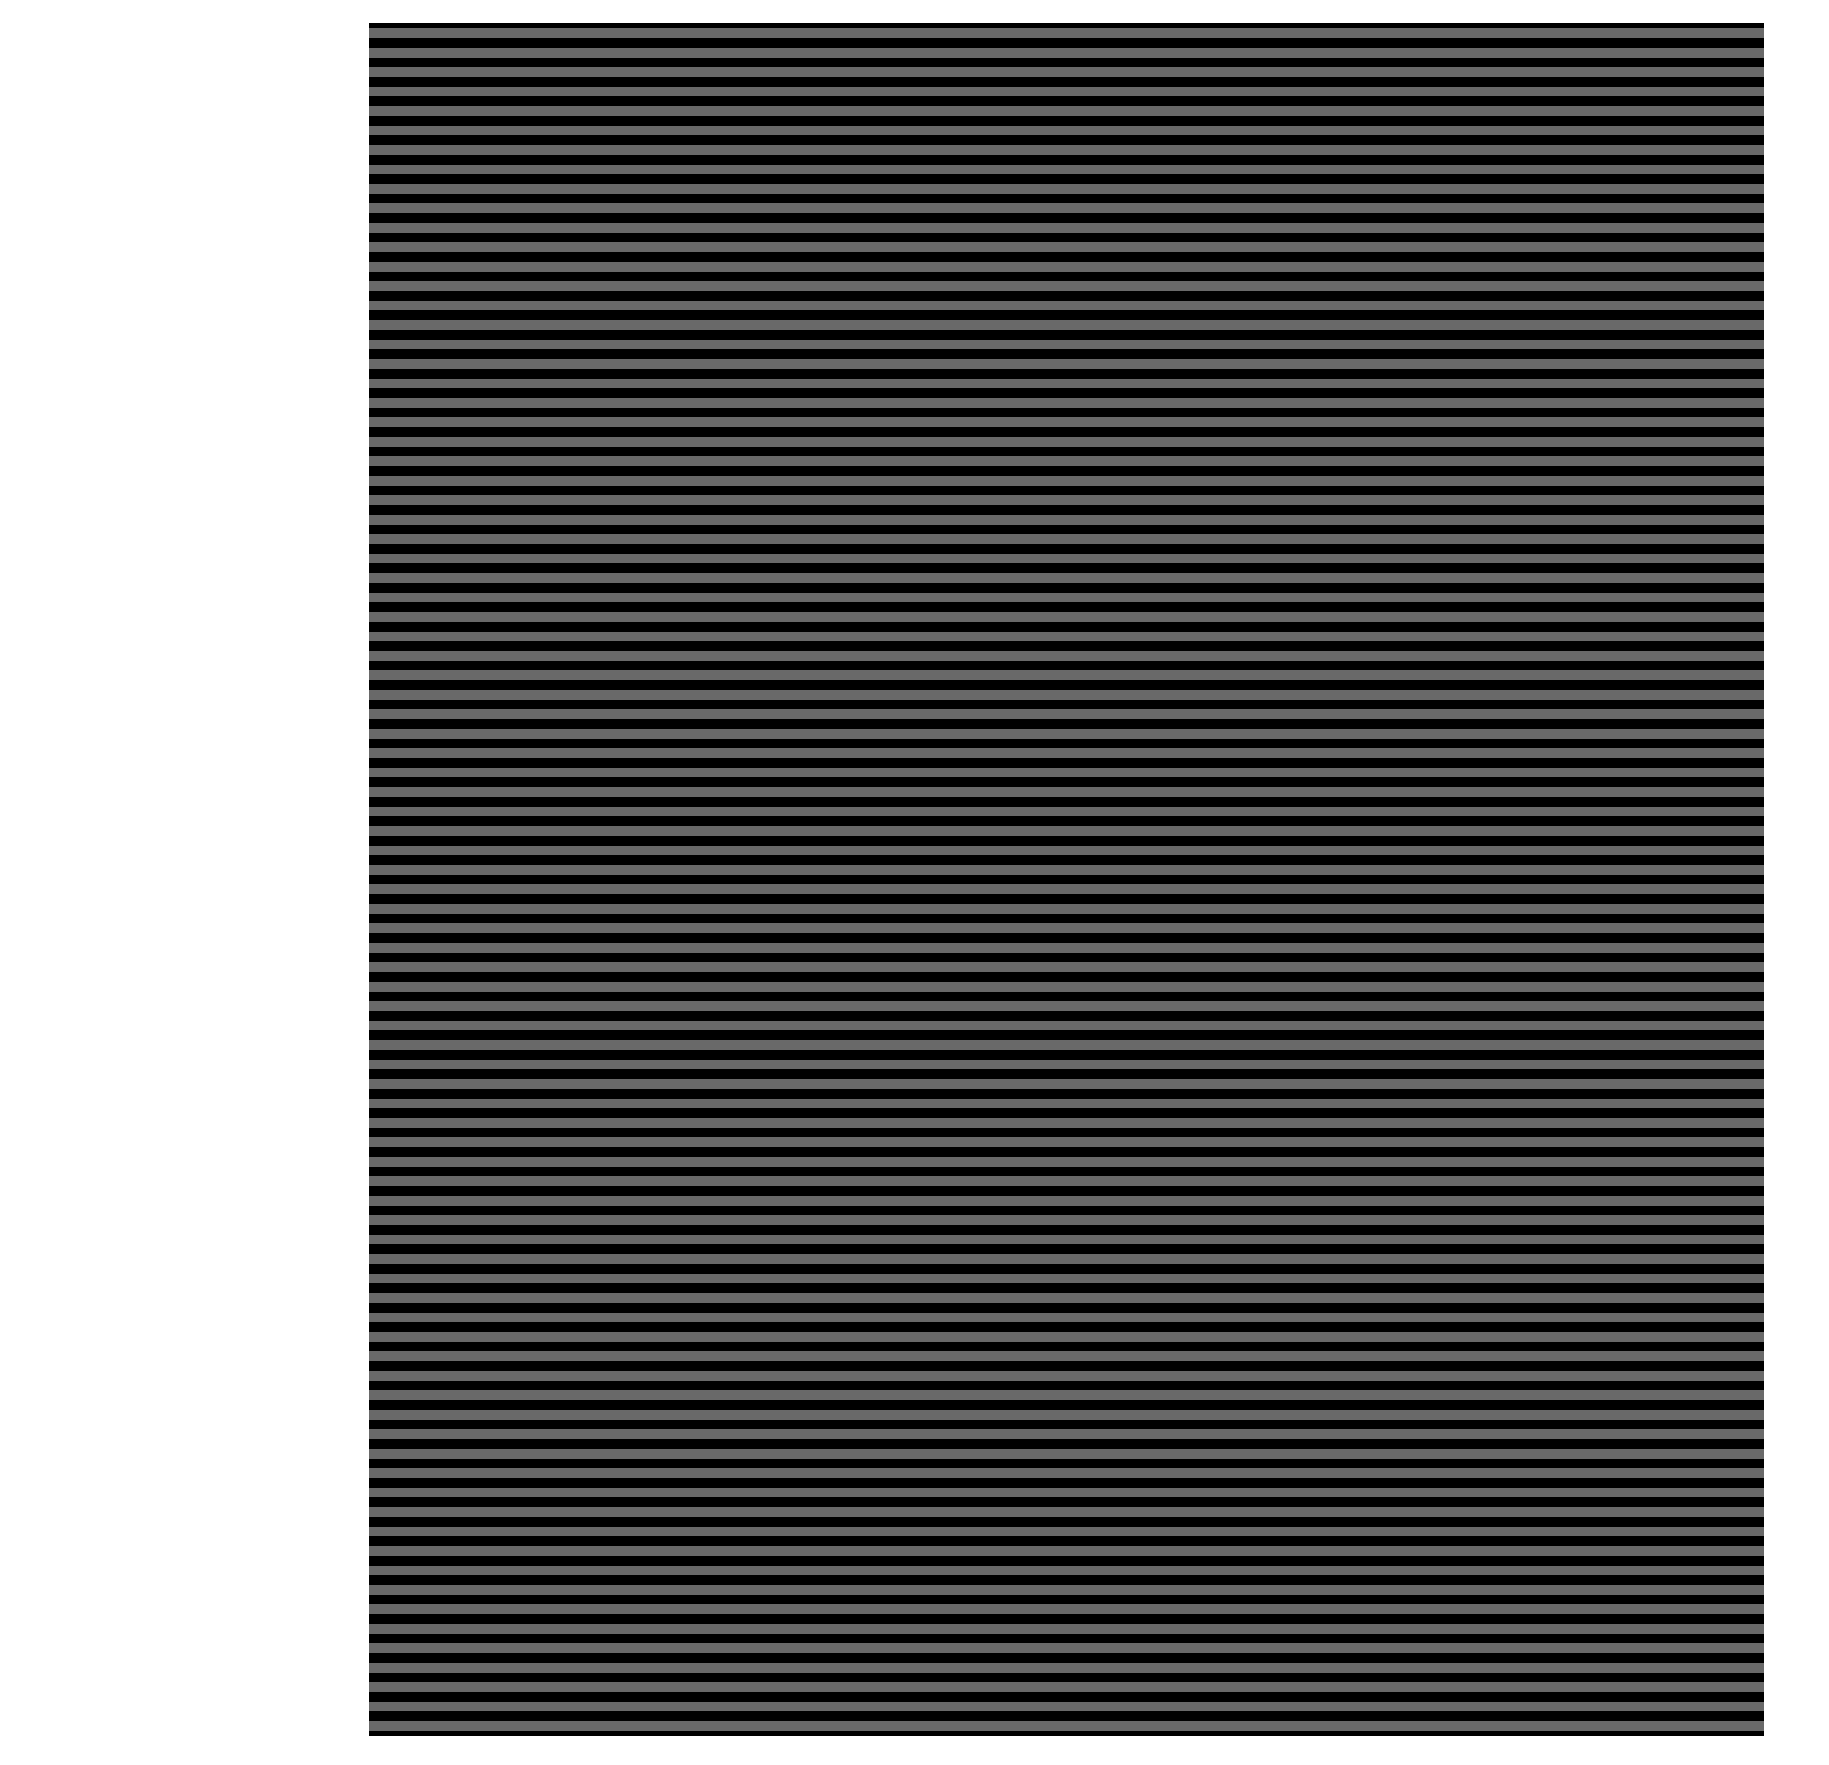

In [151]:
msn.bar(X_tr)
plt.show();

In [154]:
from sklearn.model_selection import GridSearchCV
D_tr_1= xgboost.DMatrix(X_tr, label= Y_tr)
clf= XGBClassifier(n_jobs= -1, tree_method= 'gpu_hist')

n_estimators= np.array([10, 25, 50, 100])
max_dep= np.array([3, 5, 7, 15, 50, None])
max_leafs= np.array([0, 5, 10, 20, 50])
learning_rate= np.arange(0.04, 0.40, 0.04)

params= dict(n_estimators= n_estimators, max_depth= max_dep, max_leaves= max_leafs,
            grow_policy= grow_pol, learning_rate= learning_rate)

grid= GridSearchCV(clf, param_grid= params, scoring= 'accuracy', n_jobs= -1, verbose= 2)
grid.fit(X_tr, Y_tr)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


KeyboardInterrupt: 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


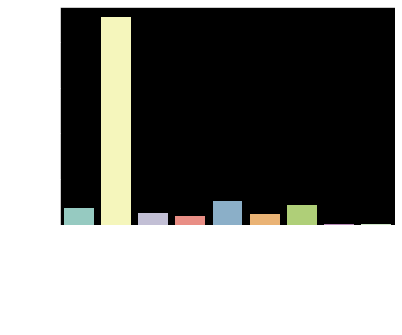

In [25]:
sns.countplot(df['workclass'])
plt.xticks(rotation= 90)
plt.show();

In [46]:
df_predna= df.dropna(how= 'any')
pd.get_dummies()
df_na= df.loc[df['workclass'].isna()]

In [49]:
X_train, x_test, Y_train, y_test= train_test_split(df_predna.iloc[:, :-1], df_predna.iloc[:, -1], test_size= 0.2)


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


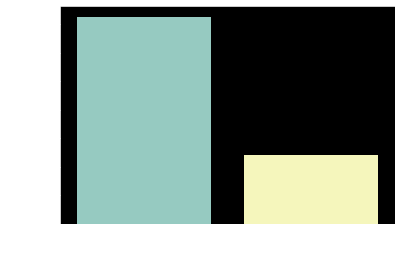

In [50]:
sns.countplot(Y_train)
plt.show();